In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as rq
import numpy as np
import time
import pickle
from io import BytesIO
from PIL import Image
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from collections import Counter
import cv2
import itertools
import seaborn as sns
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /home/pidoux/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
hashtag = 'cat'     ############ a modifier en fonction de la classe

with open(f'dataframe_{hashtag}.pkl', 'rb') as file : 
    df = pickle.load(file)
test = df
print(df.head(2))
images =  test.iloc[:]['image']

                                                 url  \
0  https://cdn.masto.host/mastodonart/media_attac...   
1  https://files.mastodon.social/media_attachment...   

                                               image  
0  [[[53, 6, 0], [59, 12, 6], [69, 22, 14], [86, ...  
1  [[[18, 17, 25], [20, 19, 27], [11, 10, 18], [1...  


In [3]:
def analyse_taille_images(images):
    shape_images = [img.shape for img in images]
    df_shape = pd.DataFrame(shape_images, columns=['height', 'width', 'channel'])
    df_shape['height*width'] = df_shape['height'] * df_shape['width']
    df_shape['width/height'] = df_shape['width'] / df_shape['height']
    df_shape = df_shape[["height", "width", "height*width", 'width/height',"channel"]]
    return df_shape , df_shape.describe()

def histogramme_tailles(images,bins=50):
    tailles_images = [img.shape[0]*img.shape[1] for img in images]
    plt.hist(tailles_images, bins=bins)
    plt.xlabel('Taille de l\'image')
    plt.ylabel('Nombre d\'images')
    plt.title('Histogramme des tailles des images ')
    plt.show()
    
def dynamique_luminosite(images):
    mean_red = []
    min_red = []
    max_red = []
    mean_green = []
    min_green = []
    max_green = []
    mean_blue = []
    min_blue = []
    max_blue = []
    variance_red = []
    variance_green = []
    variance_blue = []

    # Parcourez chaque image dans la liste
    for image in images:
        # Lisez l'image en utilisant OpenCV
        
        # Séparez les canaux de couleur
        blue, green, red = cv2.split(image)
        
        # Calculez la moyenne et la variance pour chaque canal
        mean_red.append(red.mean())
        mean_green.append(green.mean())
        mean_blue.append(blue.mean())
        min_red.append(red.min())
        min_green.append(green.min())   
        min_blue.append(blue.min())
        max_red.append(red.max())
        max_green.append(green.max())
        max_blue.append(blue.max())
        variance_red.append(red.var())
        variance_green.append(green.var())
        variance_blue.append(blue.var())

    # Créez un DataFrame Pandas
    data = {
        'Mean_Red': mean_red,
        'Mean_Green': mean_green,
        'Mean_Blue': mean_blue,
        'Variance_Red': variance_red,
        'Variance_Green': variance_green,
        'Variance_Blue': variance_blue,
        'Min_Red': min_red,
        'Min_Green': min_green,
        'Min_Blue': min_blue,
        'Max_Red': max_red,
        'Max_Green': max_green,
        'Max_Blue': max_blue
    }

    return pd.DataFrame(data), pd.DataFrame(data).describe()

def analyse_images(images,bins = 20):
    df_shape, describe_shape = analyse_taille_images(images)
    describe_shape
    hist = histogramme_tailles(images, bins = 20)
    df_dyn, describe_dyn = dynamique_luminosite(images)
    describe_dyn
    return df_shape, describe_shape, hist, df_dyn, describe_dyn

def resize_and_crop_image(image, deformation, target_size=512):
    
    # Calculez l'aspect ratio
    height, width, _ = image.shape
    aspect_ratio = width / height
    i=0
    
    # Déterminez si l'image doit être recadrée ou redimensionnée
    if 1-deformation <= aspect_ratio <= 1+deformation:
        # Redimensionnez en 512x512 sans recadrer
        resized_image = cv2.resize(image, (target_size, target_size))
    else:
        # Recadrez en centrant en fonction de la plus petite dimension
        if aspect_ratio > 1:

            new_width = height
            marge = (width - new_width) // 2
            cropped_image = image[:, marge:marge+new_width, :]
            resized_image = cv2.resize(cropped_image, (target_size, target_size))
        else:
            new_height = width
            marge = (height - new_height) // 2
            cropped_image = image[marge:marge+new_height, :, :]
            resized_image = cv2.resize(cropped_image, (target_size, target_size))
        i+=1

    return i,resized_image

def redimensionner_images(images, deformation =0.1, target_size = 512):
    images_redimensionnees = []
    tot = 0
    for image in images:
        i,image_redimensionnee = resize_and_crop_image(image, deformation, target_size)
        tot+=i
        images_redimensionnees.append(image_redimensionnee)
    print('pourcentage croped : ',tot/len(images))
    return images_redimensionnees

def normalise(images):
    output =[]
    for image in images:
        image = image / 255
        output.append(image)
    return output

def reshape_normalize(images, target_size =512, deformation = 0.1):
    images = redimensionner_images(images, deformation= deformation, target_size = target_size)
    images = normalise(images)
    return images

def image_moyenne(images):
    w,h,c = np.array(images[0]).shape #toutes les images ont les mêmes dimensions (width, height, color space)

    # Calcul de l'image moyenne
    avg_image = np.zeros((h, w, c), np.float32)

    for img in images:
        avg_image += np.array(img) / len(images)

    return avg_image


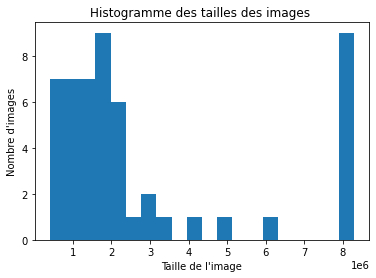

In [4]:
df_shape_pre, describe_shape_pre, hist_shape_pre, df_dyn_pre, describe_dyn_pre = analyse_images(images,bins = 20)

In [5]:
describe_shape_pre

,height,width,height*width,width/height,channel
count,52.000000,52.000000,5.200000e+01,52.000000,52.0
mean,1601.480769,1577.788462,2.933911e+06,1.030780,3.0
std,781.213950,783.411502,2.681796e+06,0.331329,0.0
min,575.000000,567.000000,4.020030e+05,0.450195,3.0
25%,1108.250000,1023.500000,1.167208e+06,0.750075,3.0
50%,1425.000000,1223.500000,1.841152e+06,1.000000,3.0
75%,1706.250000,2012.000000,3.125747e+06,1.333333,3.0
max,3838.000000,3534.000000,8.295105e+06,1.777778,3.0


In [6]:
describe_dyn_pre

,Mean_Red,Mean_Green,Mean_Blue,Variance_Red,Variance_Green,Variance_Blue,Min_Red,Min_Green,Min_Blue,Max_Red,Max_Green,Max_Blue
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,106.017054,115.297466,123.598366,3516.708493,3641.877308,3905.678279,1.211538,1.384615,1.884615,247.942308,249.538462,251.173077
std,43.705477,38.520530,38.486371,1759.447923,1515.864267,1478.930717,6.020672,5.445465,5.819689,18.230994,15.143058,10.813429
min,41.457969,42.591703,53.073416,298.023517,275.226631,457.907329,0.000000,0.000000,0.000000,160.000000,171.000000,192.000000
25%,71.803787,88.343188,100.380111,2321.558153,2663.935929,3045.961858,0.000000,0.000000,0.000000,255.000000,254.500000,255.000000
50%,98.087847,108.085505,111.453633,3230.837349,3678.708660,3922.802533,0.000000,0.000000,0.000000,255.000000,255.000000,255.000000
75%,130.742267,134.270288,149.672479,4497.018450,4273.421408,4620.540794,0.000000,0.000000,0.000000,255.000000,255.000000,255.000000
max,223.843294,223.989334,226.381941,7794.960229,7911.665989,7941.532046,32.000000,31.000000,31.000000,255.000000,255.000000,255.000000


pourcentage croped :  0.8269230769230769


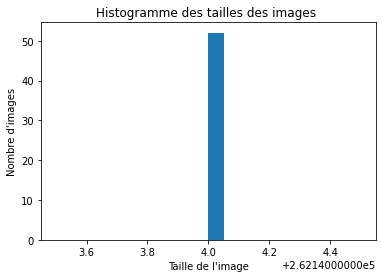

In [7]:
images = reshape_normalize(images,512,0.1)
plt.show()
df_shape_post,describe_shape_post, hist_shape_post, df_dyn_post, describe_dyn_post = analyse_images(images,bins = 20)

In [8]:
describe_shape_post

,height,width,height*width,width/height,channel
count,52.0,52.0,52.0,52.0,52.0
mean,512.0,512.0,262144.0,1.0,3.0
std,0.0,0.0,0.0,0.0,0.0
min,512.0,512.0,262144.0,1.0,3.0
25%,512.0,512.0,262144.0,1.0,3.0
50%,512.0,512.0,262144.0,1.0,3.0
75%,512.0,512.0,262144.0,1.0,3.0
max,512.0,512.0,262144.0,1.0,3.0


In [9]:
describe_dyn_post

,Mean_Red,Mean_Green,Mean_Blue,Variance_Red,Variance_Green,Variance_Blue,Min_Red,Min_Green,Min_Blue,Max_Red,Max_Green,Max_Blue
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.408165,0.444734,0.476479,0.054303,0.056193,0.060398,0.008069,0.010181,0.011689,0.952489,0.960709,0.970287
std,0.167718,0.147495,0.148445,0.027591,0.023675,0.024255,0.030011,0.028228,0.028507,0.089606,0.072562,0.058365
min,0.162598,0.167210,0.208311,0.004552,0.004220,0.006995,0.000000,0.000000,0.000000,0.592157,0.658824,0.745098
25%,0.269619,0.352827,0.382696,0.037870,0.042110,0.046020,0.000000,0.000000,0.000000,0.931373,0.963725,0.979412
50%,0.373593,0.411520,0.444933,0.050292,0.056423,0.058227,0.000000,0.000000,0.000000,1.000000,0.996078,1.000000
75%,0.498049,0.518491,0.571549,0.069901,0.070231,0.070736,0.000000,0.003922,0.007843,1.000000,1.000000,1.000000
max,0.859140,0.859863,0.868709,0.135561,0.121739,0.122007,0.164706,0.152941,0.152941,1.000000,1.000000,1.000000


In [10]:
hashtag = 'cat' ############ a modifier en fonction de la classe
df = pd.DataFrame({'image':images})
with open(f'images_{hashtag}.pkl', 'wb') as file : 
    pickle.dump(df, file)
with open(f'images_shape_original{hashtag}.pkl', 'wb') as file : 
    pickle.dump(df_shape_pre, file)
with open(f'images_dyn_original{hashtag}.pkl', 'wb') as file : 
    pickle.dump(df_dyn_pre, file)
    
    
    # ne pas oublier de faire clique droit sur les histo pour les enregistrer

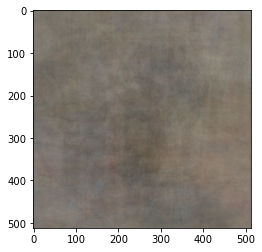

In [11]:
avg_image = image_moyenne(images)
plt.imshow(avg_image)